In [4]:
from bs4 import BeautifulSoup
import requests
from urllib.parse import urlparse

import json, os, re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

import string

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import wordcloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver

     |████████████████████████████████| 911kB 2.8MB/s 
Get:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:12 https://clo

####Functions

In [0]:
def abstracts_to_grams_freq(abstracts_df=abstracts, n_grams=2, convert_to_lower=True, remove_non_alpha=True, remove_stop_word=True, stop_word_list=None):
  
  abstracts = [abstract for abstract in abstracts_df.values]

  # clean
  # convert to lower case
  if convert_to_lower:
    abstracts = [abstract.lower() for abstract in abstracts]
  # remove remaining tokens that are not alphabetic
  if remove_non_alpha:
    abstracts = [''.join([i for i in abstract if i.isalpha() or i==" " or i=="-"]) for abstract in abstracts]

  # tokenize 
  abstracts_tokens = [ word_tokenize(abstract) for abstract in abstracts]

  # filter out stop words
  if remove_stop_word:
    if not stop_word_list:
      raise ValueError('abstracts_to_tokens_freq: remove_stop_word arg. is True but stop_word_list arg. is None')
    else:
      abstracts_tokens = [ [token for token in abstract_tokens if token not in stop_word_list] for abstract_tokens in abstracts_tokens]

  abstracts_grams = [ nltk.ngrams( abstract_tokens, n_grams) for abstract_tokens in abstracts_tokens ]
  # flatten
  abstracts_grams = [ abstract_grams for abstract in abstracts_grams for abstract_grams in abstract]

  # get unique words
  unique_grams, counts = np.unique(abstracts_grams, axis=0, return_counts=True)
  # sort by count (most frequent to less frequent)
  indices = np.argsort(counts, )
  sorted_unique_grams = unique_grams[indices][::-1]
  sorted_counts = counts[indices][::-1]
  # normalize counts as frequency
  n_all_grams = np.sum(counts)
  sorted_frequencies = [ count/n_all_grams for count in sorted_counts]



  # reshape as dataframe
  token_freq_tuples = list(zip(sorted_unique_grams, sorted_counts, sorted_frequencies)) 
  token_freq_df = pd.DataFrame(token_freq_tuples, columns=["token", "count", "frequency"])

  return token_freq_df

In [0]:
def generate_word_cloud_from_gram_freq_df(gram_freq_df, **kwargs):

  max_font_size = kwargs.get("max_font_size", 70)
  max_words = kwargs.get("max_words", 100)
  background_color = kwargs.get("background_color", "white")
  width = kwargs.get("width", 600)
  height = kwargs.get("height", 400) 
  figsize = kwargs.get("figsize", (10,10))
  title = kwargs.get("title", "")

  freq_dict = {}
  for gram, freq in gram_freq_df.values:
      gram = " ".join(gram)
      freq_dict[gram] = freq

  word_cloud_gen = wordcloud.WordCloud(max_font_size=max_font_size,
                                       max_words = max_words,
                                       background_color = background_color,
                                       width = width,
                                       height = height)
  
  word_cloud_gen.generate_from_frequencies(frequencies=freq_dict)
  plt.figure(figsize = figsize)
  plt.imshow(word_cloud_gen, interpolation="bilinear")
  plt.title(title)
  plt.axis("off")
  plt.show()

In [0]:
def levenshtein_ratio_and_distance(s, t, ratio_calc = True):
    """ levenshtein_ratio_and_distance:
        Calculates levenshtein distance between two strings.
        If ratio_calc = True, the function computes the
        levenshtein distance ratio of similarity between two strings
        For all i and j, distance[i,j] will contain the Levenshtein
        distance between the first i characters of s and the
        first j characters of t
    """
    # Initialize matrix of zeros
    rows = len(s)+1
    cols = len(t)+1
    distance = np.zeros((rows,cols),dtype = int)

    # Populate matrix of zeros with the indeces of each character of both strings
    for i in range(1, rows):
        for k in range(1,cols):
            distance[i][0] = i
            distance[0][k] = k

    # Iterate over the matrix to compute the cost of deletions,insertions and/or substitutions    
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0 # If the characters are the same in the two strings in a given position [i,j] then the cost is 0
            else:
                # In order to align the results with those of the Python Levenshtein package, if we choose to calculate the ratio
                # the cost of a substitution is 2. If we calculate just distance, then the cost of a substitution is 1.
                if ratio_calc == True:
                    cost = 2
                else:
                    cost = 1
            distance[row][col] = min(distance[row-1][col] + 1,      # Cost of deletions
                                 distance[row][col-1] + 1,          # Cost of insertions
                                 distance[row-1][col-1] + cost)     # Cost of substitutions
    if ratio_calc == True:
        # Computation of the Levenshtein Distance Ratio
        Ratio = ((len(s)+len(t)) - distance[row][col]) / (len(s)+len(t))
        return Ratio
    else:
        # print(distance) # Uncomment if you want to see the matrix showing how the algorithm computes the cost of deletions,
        # insertions and/or substitutions
        # This is the minimum number of edits needed to convert string a to string b
        return "The strings are {} edits away".format(distance[row][col])

### Getting The Papers Titles from ICSE, ICSt, FSE, ASE, ISSTA, ISSRE

In [0]:
root_link = "https://dblp.org/db/conf/"
conf_links = [ "icse/icse", "icst/icst", "sigsoft/fse", "kbse/ase", "issta/issta", "issre/issre"]
years = ["2017", "2018", "2019"]

In [0]:
software_engineering_confs = {}

for conf in conf_links:
  software_engineering_confs[conf] = {}
  for year in years:
    
    software_engineering_confs[conf][year]=[]

    link = root_link+conf+year+".html"
    print("Processing Conf.: %s"%link)

    conf_page = requests.get(link)
    
    if  not conf_page.status_code == requests.codes.ok:
      # No data available for this conference
      continue

    conf_soup = BeautifulSoup(conf_page.content, 'html5lib')

    # Get Puplication Lists (ul tag with class publ-list)
    publ_lists = conf_soup.find_all("ul", class_="publ-list")

    # Ignore First publ_list (it is related to the conference)
    for publ_list in publ_lists[1:]:

      # Get the previous header sibling (each publist is preceeded with a header tag explaining the topic of the paper)
      # we will use those as tags for the papers
      papers_topic = publ_list.find_previous_sibling("header").text
      print("Processing papers of topic: %s"%papers_topic)

      # Get publications
      publ_list_publications = publ_list.find_all("li", class_="entry inproceedings")

      # Loop on publications
      for publ in publ_list_publications:

        # Get publication id
        publ_id = publ.attrs["id"]

        # Get publication title
        publ_title = publ.find("span", class_="title").text

        # Get publication authors
        publ_authors = [author.text for author in publ.find_all("span", itemprop="author")]

        # Add top as a tag
        publ_tags = [papers_topic]

        # Get DOI links

        links_tags = publ.find("nav", class_="publ").find_all("li", class_="ee")
        links = [ link.find("a").attrs["href"] for link in links_tags]
        
        print("Read Publication: %s"%publ_title)

        # Add paper to conf-year dictionary
        software_engineering_confs[conf][year].append({"id": publ_id,
                                                      "title": publ_title,
                                                      "authors": publ_authors,
                                                      "DOIs": links,
                                                      "tag": publ_tags})

In [0]:
# save output
json.dump(software_engineering_confs, open("/content/drive/My Drive/Colab Notebooks/Survey SE vs ML/softwar_eng_confs_papers.json","w"))

In [0]:
# load software_engineerg_confs
software_engineering_confs = json.load(open("/content/drive/My Drive/Colab Notebooks/Survey SE vs ML/softwar_eng_confs_papers.json","r"))

### Statistics

In [0]:
import seaborn as sn

In [0]:
# json to df
software_engineering_confs_df = pd.DataFrame(columns=["Conf.", "Year", "ID", "Authors", ])
for conf_name, conf_data in software_engineering_confs.items():
  software_engineering_confs_n_papers[conf_name]={}
  software_engineering_confs_n_papers[conf_name]["conf_total"]=0
  for year, year_data in conf_data.items():
    software_engineering_confs_n_papers[conf_name]["conf_total"]+= len(year_data)
    software_engineering_confs_n_papers["total"]+=len(year_data)
    software_engineering_confs_n_papers[conf_name][year] = len(year_data)

In [0]:
# Get number of processed papers for each conference
software_engineering_confs_n_papers = {}
software_engineering_confs_n_papers["total"]=0
for conf_name, conf_data in software_engineering_confs.items():
  software_engineering_confs_n_papers[conf_name]={}
  software_engineering_confs_n_papers[conf_name]["conf_total"]=0
  for year, year_data in conf_data.items():
    software_engineering_confs_n_papers[conf_name]["conf_total"]+= len(year_data)
    software_engineering_confs_n_papers["total"]+=len(year_data)
    software_engineering_confs_n_papers[conf_name][year] = len(year_data)

##### Clean Topics

In [0]:
unclean_re = re.compile("Research track:\n.*")
for conf_name, conf_data in software_engineering_confs.items():
  for year, year_data in conf_data.items():
    for index, publ in enumerate(year_data):
      if unclean_re.match(publ["tag"][0]):
        software_engineering_confs[conf_name][year][index]["tag"] = [publ["tag"][0].split("\n")[1]] 

In [0]:
se_confs_df = pd.DataFrame(columns=["conference","year", "title", "id", "authors", "tags"])
for conf_name, conf_data in software_engineering_confs.items():
  for year, year_data in conf_data.items():
    for index, publ in enumerate(year_data):
      se_confs_df= se_confs_df.append({'conference': conf_name,
                          'year': year,
                          'title': publ["title"],
                          'id': publ["id"],
                          'authors': ", ".join(publ["authors"]),
                          "tags": ", ".join(publ["tag"])}, ignore_index=True)
se_confs_df.to_csv("/content/drive/My Drive/Colab Notebooks/Survey SE vs ML/softwar_eng_confs_papers.csv")

##### All Topics

In [0]:
all_topics = [publ["tag"][0] for conf in software_engineering_confs.values() for year in conf.values() for publ in year ]
np.unique(all_topics)

##### All Title

In [0]:
all_titles = [publ["title"] for conf in software_engineering_confs.values() for year in conf.values() for publ in year ]
all_titles_tokens = []
for title in all_titles:
  all_titles_tokens.extend(word_tokenize(title))

In [0]:
# convert to lower case
#all_titles_tokens = [w.lower() for w in all_titles_tokens]

# remove punctuation from each word
table = str.maketrans('', '', string.punctuation)
stripped = [w.translate(table) for w in all_titles_tokens]

# remove remaining tokens that are not alphabetic
words = [word for word in stripped if word.isalpha()]

# filter out stop words
stop_words = set(stopwords.words('english'))
words = [w for w in words if not w in stop_words]

# get unique words
unique_words, counts = np.unique(words, return_counts=True)

# sort by count (most frequent to less frequent)
indices = np.argsort(counts, )
sorted_unique_words = unique_words[indices][::-1]

list(sorted_unique_words)


### Get The Abstract of Each Paper

In [0]:
# Prepare Selenium
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
# open it, go to a website, and get results
wd = webdriver.Chrome('chromedriver',options=options)

for conf_name, conf_data in software_engineering_confs.items():
  print("Processing %s"%(conf_name))
  for year, year_data in conf_data.items():
    print("Processing %s"%(year))
    for publ_index, publ in enumerate(year_data):
        # conf_name = "icse/icse"; year="2017"; publ_index=0;
        # publ = software_engineering_confs[conf_name]["2018"][0]
        # TODO Delete Comments
        print("Processing Paper %s"%(conf_name+"/"+year+"/"+publ["title"]))

        # Get Publication details from IEEE DOI
        
        # Get DOI
        doi_link = publ["DOIs"][0]

        if "ieeecomputersociety" in doi_link:
          wd.get(doi_link)
          publ_details_response = wd.page_source
          
          # Get results as HTML
          publ_details_soup = BeautifulSoup(publ_details_response, 'html')

          # Get abstract container
          abstract_container = publ_details_soup.find("csdl-article-full-text")

          # Get abstract
          publ_abstract = abstract_container.text.replace("\n","").strip()

        else:

          # Get DOI Redirection
          publ_link = BeautifulSoup(requests.get(url = doi_link, allow_redirects=False).content).find("a").attrs["href"]

          # Check Redirection URL
          if "ieeexplore.ieee.org" in publ_link:

            print("Redirection %s"%(urlparse(publ_link).netloc))

            # Get Publication Details
            wd.get(url = publ_link)
            #publ_details_response = wd.page_source

            # Get results as HTML
            #publ_details_soup = BeautifulSoup(publ_details_response, 'html')

            # Get abstract container
            #abstract_container = publ_details_soup.find("div", class_="abstract-text")

            # Get abstract
            publ_abstract = wd.execute_script("return global.document.metadata['abstract'];").replace("\n","").strip()

          elif "dl.acm.org" in publ_link:

            print("Redirection %s"%(urlparse(publ_link).netloc))

            # Get Publication Details
            wd.get(url = publ_link)
            publ_details_response = wd.page_source

            # Get results as HTML
            publ_details_soup = BeautifulSoup(publ_details_response, 'html')

            # Get abstract container
            abstract_container = publ_details_soup.find("div", class_="hlFld-Abstract")

            # Get abstract
            publ_abstract = abstract_container.text.replace("\n","").strip()


        # Add it to the dicitonary
        print("Abstract: %s"%(publ_abstract[:100]))
        software_engineering_confs[conf_name][year][publ_index]["abstract"] = publ_abstract

    # save output
    json.dump(software_engineering_confs, open("/content/drive/My Drive/Colab Notebooks/Survey SE vs ML/softwar_eng_confs_papers_with_abst.json","w"))
wd.close()

### Statistic

In [0]:
# load software_engineerg_confs with abstract
software_engineering_confs = json.load(open("/content/drive/My Drive/Colab Notebooks/Survey SE vs ML/softwar_eng_confs_papers_with_abst.json","r"))

In [0]:
n_publ={}
n_publ_with_bstract={}
for conf_name, conf_data in software_engineering_confs.items():
  n_publ[conf_name]=0
  n_publ_with_bstract[conf_name]=0
  for year, year_data in conf_data.items():
    for publ_index, publ in enumerate(year_data):
      n_publ[conf_name]+=1
      if 'abstract' in publ.keys():
        n_publ_with_bstract[conf_name]+=1

In [0]:
n_publ_with_bstract

In [0]:
n_publ

### Clean

In [0]:
# load software_engineerg_confs with abstract
software_engineering_confs = json.load(open("/content/drive/My Drive/Colab Notebooks/Survey SE vs ML/softwar_eng_confs_papers_with_abst.json","r"))

In [7]:
# clean data
abstract_prefix = 'abstract'
unclean_tag = re.compile("Research track:\n.*")
table = str.maketrans('', '', string.punctuation)

for conf_name, conf_data in software_engineering_confs.items():
  print("Processing %s"%(conf_name))
  for year, year_data in conf_data.items():
    print(" Processing %s"%(year))
    for publ_index, publ in enumerate(year_data):

      # print("   Before Cleaning:")
      # print("     Title: %s"%(publ["tag"][0]))
      # print("     Abstact: %s"%(publ["abstract"]))
    

      # Remove puncuation from abstracts
      publ["abstract"] = publ["abstract"].translate(table)

      # Some abstracts are trailed with 'Abstract', if so remove it 
      if publ["abstract"][:len(abstract_prefix)].lower() == abstract_prefix.lower():
        software_engineering_confs[conf_name][year][publ_index]["abstract"] = publ["abstract"][len(abstract_prefix):] 
      
      # remove punctuatuion from tags and title
      publ["tag"] = [ tag.translate(table) for tag in publ["tag"]]
      publ["title"] = publ["title"].translate(table)

      # Some tags are trailed with unrelevant information, if so remove it
      if unclean_tag.match(publ["tag"][0]):
        software_engineering_confs[conf_name][year][publ_index]["tag"] = [publ["tag"][0].split("\n")[1]] 

      # print("   After Cleaning:")
      # print("     Title: %s"%(software_engineering_confs[conf_name][year][publ_index]["tag"]))
      # print("     Abstact: %s"%(software_engineering_confs[conf_name][year][publ_index]["abstract"]))  

Processing icse/icse
 Processing 2017
 Processing 2018
 Processing 2019
Processing icst/icst
 Processing 2017
 Processing 2018
 Processing 2019
Processing sigsoft/fse
 Processing 2017
 Processing 2018
 Processing 2019
Processing kbse/ase
 Processing 2017
 Processing 2018
 Processing 2019
Processing issta/issta
 Processing 2017
 Processing 2018
 Processing 2019
Processing issre/issre
 Processing 2017
 Processing 2018
 Processing 2019


In [0]:
# Reshape as df
se_confs_df = pd.DataFrame(columns=["conference","year", "id", "title", "abstract", "authors", "tags"])
for conf_name, conf_data in software_engineering_confs.items():
  for year, year_data in conf_data.items():
    for index, publ in enumerate(year_data):
      se_confs_df= se_confs_df.append({'conference': conf_name,
                          'year': year,
                          'title': publ["title"],
                          'id': publ["id"],
                          'authors': ", ".join(publ["authors"]),
                          "tags": ", ".join(publ["tag"]),
                          "abstract": publ["abstract"]}, ignore_index=True)

In [0]:
se_confs_df = se_confs_df.replace({"conference": {"icse/icse": "ICSE",
                                    "icst/icst":"ICST",
                                    "sigsoft/fse":"FSE",
                                    "kbse/ase":"ASE",
                                    "issta/issta":"ISSTA",
                                    "issre/issre":"ISSRE"}})


###stat

In [13]:
len(se_confs_df)

1516

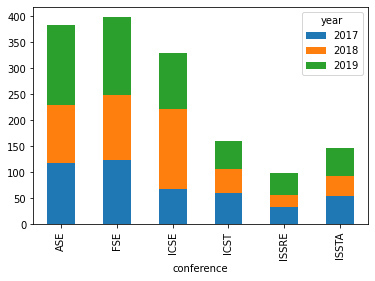

In [12]:
df2 = se_confs_df.groupby(['conference', 'year'])['id'].count().unstack('year').fillna(0)
ax= df2[['2017','2018', '2019']].plot(kind='bar', stacked=True)

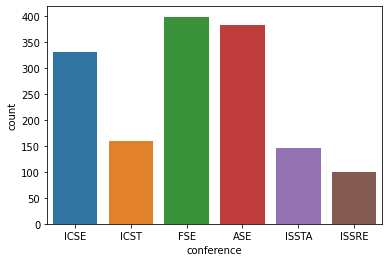

In [0]:
sns.countplot('conference', data=se_confs_df)

In [0]:
sns.distplot(se_confs_df.total_bill, color="gold", kde=False, hist_kws={"alpha": 1}) 
sns.distplot(tips[tips.sex == "Female"].total_bill, color="blue", kde=False, hist_kws={"alpha":1}) 
plt.show()

In [0]:
stop_words = set(stopwords.words('english'))
top_500_eng_words = open("/content/drive/My Drive/Colab Notebooks/Survey SE vs ML/english_500_freq_words_vocabularybuilding.txt").read().split(" ")
top_1000_eng_words = open("/content/drive/My Drive/Colab Notebooks/Survey SE vs ML/english_1000_freq_words_gonaturalenglish.txt").read().split(" ")

my_stop_words = list(set(stop_words) | set(top_500_eng_words) | set(top_1000_eng_words))

In [0]:
# Get uni-grams from all abstracts
abstracts = se_confs_df["abstract"]
token_freq_df = abstracts_to_tokens_freq(abstracts,
                                         convert_to_lower=True,
                                         remove_non_alpha=True,
                                         remove_stop_word=True,
                                         stop_word_list= my_stop_words )
generate_word_cloud_from_token_freq_df( token_freq_df.iloc[:, [0,2]],
                                       max_font_size=100,
                                       figsize=(20,20),
                                       width=800, hight=400)

In [0]:
# abstracts uni-grams per each conference
confs = se_confs_df["conference"].unique()

for conf in confs:
  abstracts =  se_confs_df[ se_confs_df["conference"] == conf ]["abstract"]
  token_freq_df = abstracts_to_tokens_freq(abstracts,
                                         convert_to_lower=True,
                                         remove_non_alpha=True,
                                         remove_stop_word=True,
                                         stop_word_list= my_stop_words )
  generate_word_cloud_from_token_freq_df( token_freq_df.iloc[:, [0,2]],
                                       max_font_size=100,
                                       figsize=(20,20),
                                       title= " Word Cloud of %s abstracts"%(conf.split("/")[1]),
                                       width=800, hight=400)

In [0]:
# all abstracts bi_grams
abstracts = se_confs_df["abstract"]
gram_freq_df = abstracts_to_grams_freq(abstracts,
                                       n_grams=2,
                                       convert_to_lower=True,
                                       remove_non_alpha=True,
                                       remove_stop_word=True,
                                       stop_word_list= my_stop_words )

generate_word_cloud_from_gram_freq_df( gram_freq_df.iloc[:, [0,2]],
                                       max_font_size=100,
                                       figsize=(20,20),
                                       width=800, hight=400)

In [0]:
# abstracts uni-grams per each conference
confs = se_confs_df["conference"].unique()

for conf in confs:
  abstracts =  se_confs_df[ se_confs_df["conference"] == conf ]["abstract"]
  token_freq_df = abstracts_to_grams_freq(abstracts,
                                         n_grams=2,
                                         convert_to_lower=True,
                                         remove_non_alpha=True,
                                         remove_stop_word=True,
                                         stop_word_list= my_stop_words )
  generate_word_cloud_from_gram_freq_df( token_freq_df.iloc[:, [0,2]],
                                       max_font_size=100,
                                       figsize=(20,20),
                                       title= " Word Cloud of %s abstracts"%(conf.split("/")[1]),
                                       width=800, hight=400)

In [0]:
# neural network frequency
years = se_confs_df["year"].unique()
nn_freq = {}
for year in years:
  nn_freq[year]=0
  abstracts = se_confs_df[se_confs_df["year"]==year]["abstract"]
  gram_freq_df = abstracts_to_grams_freq(abstracts,
                                       n_grams=3,
                                       convert_to_lower=True,
                                       remove_non_alpha=True,
                                       remove_stop_word=True,
                                       stop_word_list= my_stop_words )
  
  gram_freq_df["token"] = [ " ".join(token).lower() for token in gram_freq_df["token"].values]
  
  nn_freq[year] = gram_freq_df[ gram_freq_df["token"].str.contains("neural network")  ]["frequency"].values

{'2017': array([], dtype=float64),
 '2018': array([7.31136674e-05, 2.43712225e-05, 2.43712225e-05, 2.43712225e-05,
        2.43712225e-05, 2.43712225e-05, 2.43712225e-05, 2.43712225e-05,
        2.43712225e-05, 2.43712225e-05, 2.43712225e-05, 2.43712225e-05,
        2.43712225e-05, 2.43712225e-05]),
 '2019': array([8.74336051e-05, 4.37168026e-05, 4.37168026e-05, 4.37168026e-05,
        2.18584013e-05, 2.18584013e-05, 2.18584013e-05, 2.18584013e-05,
        2.18584013e-05, 2.18584013e-05, 2.18584013e-05, 2.18584013e-05,
        2.18584013e-05, 2.18584013e-05, 2.18584013e-05, 2.18584013e-05,
        2.18584013e-05, 2.18584013e-05, 2.18584013e-05, 2.18584013e-05,
        2.18584013e-05, 2.18584013e-05, 2.18584013e-05, 2.18584013e-05,
        2.18584013e-05, 2.18584013e-05, 2.18584013e-05, 2.18584013e-05,
        2.18584013e-05, 2.18584013e-05, 2.18584013e-05, 2.18584013e-05])}